## Figures

- Figure 5 D,E
- Figure S7A,C,D
  
## Required files

- `{model_dir}/seq_model.pkl`
- `{model_dir}/deeplift/{t}/out/{imp_score}/modisco.h5`
- `{dataset_dir}/dfabf.Oct4-Sox2-subset.parq`


## Produced files

`figures_dir = f"{ddir}/figures/modisco/{exp}/in-vivo-perturb"`

- Figure 5D
  - `{figures_dir}/short-range.Nanog<>Sox2.strand_combination=all.pdf`
  - `{figures_dir}/long-range.Oct4-Sox2.strand_combination=all.pdf`
- Figure 5E
  - `{figures_dir}/heatmap.median_max_profile_count.directional_effect.top-profile.bleed-through-corrected.pdf`
- Figure S7A
  - `{ddir}/figures/modisco/{exp}/in-vivo-perturb/oct4-enhancer/wt.pdf`
  - `{ddir}/figures/modisco/{exp}/in-vivo-perturb/oct4-enhancer/dOct4-Sox2.pdf`
  - `{ddir}/figures/modisco/{exp}/in-vivo-perturb/oct4-enhancer/dNanog.pdf`
- Figure S7C,D
  - `{figures_dir}/max_profile_count.upper-triag.no-Oct4.width=0.65.center_diff>5.pdf`

In [1]:
from collections import OrderedDict
exp = 'nexus,peaks,OSNK,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE'
imp_score = 'profile/wn'

motifs = OrderedDict([
    ("Oct4-Sox2", 'Oct4/m0_p0'),
    ("Sox2", 'Sox2/m0_p1'),
    ("Nanog", 'Nanog/m0_p1'),
    ("Klf4", 'Klf4/m0_p0'),
])

## Figure 5,6

In [2]:
# Imports
from basepair.imports import *
from basepair.exp.paper.config import models_dir, profile_mapping, ddir
from basepair.exp.chipnexus.perturb.vdom import vdom_motif_pair, plot_spacing_hist
from basepair.exp.chipnexus.spacing import remove_edge_instances, get_motif_pairs
from basepair.exp.paper.config import tasks
from plotnine import *
import plotnine
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
paper_config()

Using TensorFlow backend.


In [3]:
model_dir = models_dir / exp
dataset_dir = model_dir / 'perturbation-analysis'

In [8]:
pairs = get_motif_pairs(motifs)

# ordered names
pair_names = ["<>".join(x) for x in pairs]

In [9]:
figures_dir = Path(f"{ddir}/figures/modisco/{exp}/in-vivo-perturb")

In [10]:
!mkdir -p {figures_dir}

In [11]:
# define the global set of distances
dist_subsets = ['center_diff<=35',
               '(center_diff>35)&(center_diff<=70)', 
               '(center_diff>70)&(center_diff<=150)', 
               'center_diff>150']
dist_subset_labels = ['dist < 35',
                      '35 < dist <= 70',
                      '70 < dist <= 150',
                      '150 < dist',
                     ]

['#67001f',
 '#bb2a34',
 '#e58368',
 '#fbceb7',
 '#f6f7f7',
 '#c0dceb',
 '#68abd0',
 '#2870b1',
 '#053061']

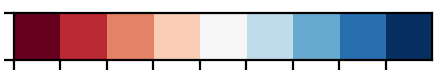

In [16]:
from basepair.plot.utils import PlotninePalette

# choose the right color
colors = plt.get_cmap("RdBu")(np.linspace(0, 1, 9))
hex_colors = [plt.cm.colors.to_hex(a) for a in colors]
sns.palplot(colors,size=0.3)

cb_red = hex_colors[2]
cb_blue = hex_colors[-2 - 2]

hex_colors

## Load the data

In [9]:
from basepair.exp.chipnexus.perturb.scores import ism_compute_features_tidy, compute_features_tidy, SCORES, max_profile_count
from basepair.exp.paper.config import tasks

In [10]:
ls {dataset_dir}

dfab.csv.gz                  dfi_subset.csv.gz  ref.h5
dfabf.csv.gz                 dfs.csv.gz         ref.h5.bak
dfabf_ism.csv.gz             double_mut.h5      single_mut.h5
dfabf.Oct4-Sox2-subset.parq  double_mut.h5.bak  single_mut.h5.bak


In [36]:
# load dfabf2
dfabf2_path = dataset_dir / 'dfabf.Oct4-Sox2-subset.parq'

if not os.path.exists(str(dfabf2_path)):    
    dfabf = pd.read_csv(dataset_dir / 'dfabf.csv.gz')
    dfabf = dfabf[dfabf.motif_pair.isin(pair_names)]
    dfabf['center_diff_cat'] = pd.Categorical(pd.cut(dfabf['center_diff'], [0, 35, 70, 150, 1000]))
    print("Producinf dfabf2")
    dfi_subset = pd.read_csv(dataset_dir / 'dfi_subset.csv.gz')

    ### Add `pattern_center_aln` to `dfi_subset`
    mr = MultipleModiscoResult({t: model_dir / f'deeplift/{t}/out/{imp_score}/modisco.h5'
                               for t in tasks})
    from basepair.exp.paper.fig4 import cluster_align_patterns
    main_motifs = [mr.get_pattern(pattern_name).add_attr('features', {'n seqlets': mr.n_seqlets(pattern_name)})
                   for name, pattern_name in motifs.items()]
    main_motifs = [p.rename(longer_pattern(p.name)) for p in main_motifs]
    main_motifs_clustered = cluster_align_patterns(main_motifs, n_clusters=1)
    from basepair.modisco.pattern_instances import align_instance_center
    dfi_subset = align_instance_center(dfi_subset, main_motifs, main_motifs_clustered, trim_frac=0.08)

    ### Exclude TEs
    from basepair.modisco.pattern_instances import multiple_load_instances
    instance_parq_paths = {t: model_dir / f'deeplift/{t}/out/{imp_score}/instances.parq' 
                           for t in tasks}
    def shorten_te_pattern(s):
        tf, p = s.split("/", 1)
        return tf + "/" + shorten_pattern(p)
    motifs_te = [p.name
                 for p in mr.get_all_patterns()
                 if p.seq_info_content > 30 and mr.n_seqlets(p.name) > 100]
    motifs_te_d = OrderedDict([(shorten_te_pattern(x), shorten_te_pattern(x)) for x in motifs_te])
    # # get transposable element locations
    dfi_te = multiple_load_instances(instance_parq_paths, motifs_te_d)
    dfi_te = dfi_te[(dfi_te.match_weighted_p > 0.1) & (dfi_te.seq_match > 20)]
    # Get rows without intersecting transposable elements
    from basepair.preproc import rc_seq, dfint_no_intersection
    interval_cols = ['example_chrom', 'pattern_start_abs', 'pattern_end_abs']
    non_te_idx = dfint_no_intersection(dfi_subset[interval_cols], dfi_te[interval_cols])
    print(f"Not overlapping te's: {non_te_idx.mean()}")
    valid_row_idx = dfi_subset[non_te_idx].row_idx.values


    ### Remove all Sox2 or Oct4 instances comming from the Oct4-Sox2 motif
    def suffix_colnames(df, suffix):
        df.columns = [c + suffix for c in df.columns]
        return df
    dfabf['row_idx_x'] = dfabf['row_idx_x'].astype(int)
    dfabf['row_idx_y'] = dfabf['row_idx_y'].astype(int)
    dfabf2 = pd.merge(dfabf, dfi_subset[['row_idx',
                                         'pattern_center_aln',
                                         'pattern_strand_aln']].pipe(suffix_colnames, '_x'),
                     on='row_idx_x',
                     how='left')
    dfabf2 = pd.merge(dfabf2, dfi_subset[['row_idx',
                                          'pattern_center_aln', 
                                          'pattern_strand_aln']].pipe(suffix_colnames, '_y'),
                      on='row_idx_y',
                      how='left')
    dfabf2['pattern_diff_aln'] = dfabf2['pattern_center_aln_y'] - dfabf2['pattern_center_aln_x']
    exclude_sox2 = dfabf2[(dfabf2.motif_pair == 'Oct4-Sox2<>Sox2') & 
                          (dfabf2['pattern_diff_aln'] == 0)].row_idx_y.values
    exclude_oct4 = dfabf2[(dfabf2.motif_pair == 'Oct4-Sox2<>Oct4') & 
                          (dfabf2['pattern_diff_aln'] == 0)].row_idx_y.values

    # Exclude the overlapping row
    dfabf2 = dfabf2[(dfabf2.pattern_name_x != 'Oct4') | (~dfabf2.row_idx_x.isin(exclude_oct4))]
    dfabf2 = dfabf2[(dfabf2.pattern_name_y != 'Oct4') | (~dfabf2.row_idx_y.isin(exclude_oct4))]
    dfabf2 = dfabf2[(dfabf2.pattern_name_x != 'Sox2') | (~dfabf2.row_idx_x.isin(exclude_sox2))]
    dfabf2 = dfabf2[(dfabf2.pattern_name_y != 'Sox2') | (~dfabf2.row_idx_y.isin(exclude_sox2))]

    # Exclude TE's
    dfabf2 = dfabf2[dfabf2.row_idx_x.isin(valid_row_idx) & dfabf2.row_idx_y.isin(valid_row_idx)]
    dfabf2 = dfabf2.reset_index()

    # set categorical index
    dfabf2.center_diff_cat.cat.categories = dfabf2.center_diff_cat.cat.categories.astype(str)

    # Save dfabf
    %time dfabf2.to_parquet(dataset_dir / 'dfabf.Oct4-Sox2-subset.parq', index=False, engine='fastparquet')
else:
    print("Loading dfabf2 from file")
    dfabf2 = pd.read_parquet(dataset_dir / 'dfabf.Oct4-Sox2-subset.parq', engine='fastparquet')

In [4]:
dataset_dir / 'dfabf.Oct4-Sox2-subset.parq'

PosixPath('/oak/stanford/groups/akundaje/avsec/basepair/data/processed/comparison/output/nexus,peaks,OSNK,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE/perturbation-analysis/dfabf.Oct4-Sox2-subset.parq')

### Median binding fold change scatterplot

In [84]:
from basepair.exp.paper.config import profile_mapping

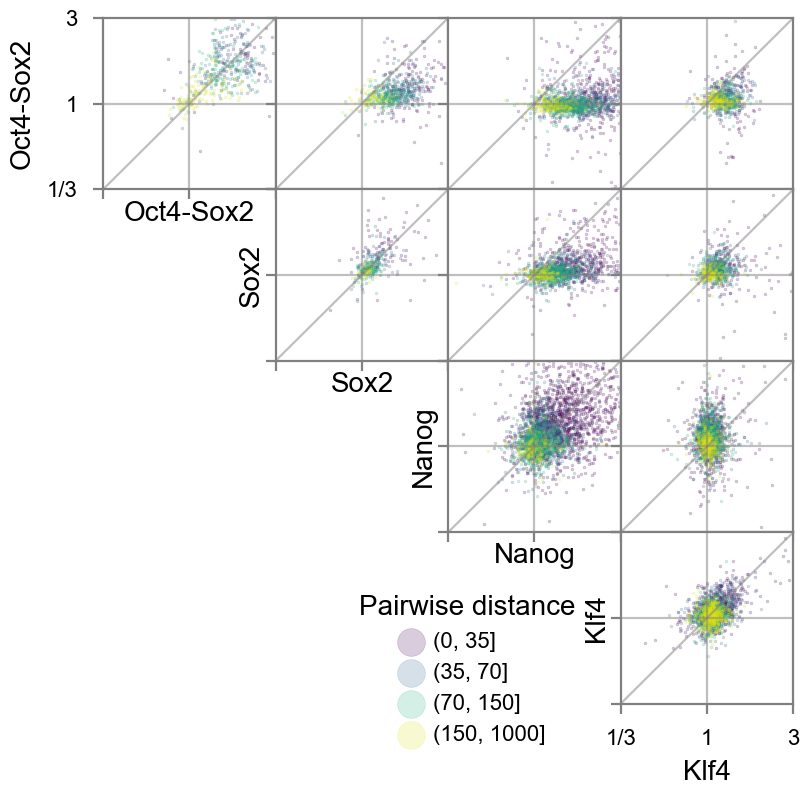

In [30]:
dfabf_plot = dfabf2.query('center_diff > 5')#.query('center_diff < 150')
score = 'max_profile_count_bt'
# -----------------------------------
fig, axes = plt.subplots(len(motifs), len(motifs), 
                         figsize=get_figsize(.65, 1), 
                         gridspec_kw=dict(wspace=0, hspace=0),
                         sharex=True, sharey=True)
colors = plt.get_cmap("viridis")(np.linspace(0, .95, len(dfabf_plot.center_diff_cat.cat.categories)))

k = 0
for i in range(len(motifs)):
    for j in range(len(motifs)):
        ax = axes[i,j]
        if i>j:
            ax.axison = False
            continue
        idx = 'motif_pair_idx'
        cat = 'center_diff_cat'
        motif_pair = pairs[k]
        motif_pair_name = "<>".join(motif_pair)
        k+=1
        t1 = profile_mapping[motif_pair[0]]
        t2 = profile_mapping[motif_pair[1]]
        # t1 = 'Nanog'
        # t2 = 'Nanog'
        # motif mask
        mmask = (dfabf_plot.motif_pair == motif_pair_name) & (dfabf_plot.score == score)
        ab = pd.merge(dfabf_plot[mmask & (dfabf_plot.task == t1)][[idx, 'x_alt_ref_pc', 'x_ref', cat]],
                      dfabf_plot[mmask & (dfabf_plot.task == t2)][[idx, 'y_alt_ref_pc', 'y_ref']],
                      on=idx)
        # make a scatterplot
        
        # Subset ab to only the highest values
        ab = ab[(ab.x_ref > np.percentile(ab.x_ref, 80)) & (ab.y_ref > np.percentile(ab.y_ref, 80))]
        for ci, (label,df) in enumerate(list(ab.groupby(cat))):
            ax.scatter(1/df.y_alt_ref_pc,
                       1/df.x_alt_ref_pc,   # first one is on the y axis
                       alpha=0.2, s=1, label=label, color=colors[ci], rasterized=True)
        
        # ax.text(0, 0,t1+"-"+t2)
        alpha = .5
        xl = [1/3, 3]
        ax.plot(xl, xl, c='grey', alpha=alpha)
        ax.axvline(1, c='grey', alpha=alpha)
        ax.axhline(1, c='grey', alpha=alpha)
        ax.set_xlim(xl)
        ax.set_ylim(xl)
        
        ax.set_yscale('log')
        ax.set_xscale('log')
        
        # explicitly add ticks
        ax.set_yticks([1/3, 1, 3])
        ax.set_xticks([1/3, 1, 3])
        ax.set_xticklabels(['1/3', '1', '3'])
        ax.set_yticklabels(['1/3', '1', '3'])
        ax.minorticks_off() # turns off minor ticks
        
        if i == j:
            ax.set_ylabel(motif_pair[1])
            ax.set_xlabel(motif_pair[0])
            
        # Use grey spines
        plt.setp(ax.spines.values(), color='grey')
        plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='grey')

plt.legend(loc="bottom right", bbox_to_anchor=(-.2,.7),
           scatterpoints=1, markerscale=10, columnspacing=0,
           handletextpad=0, borderpad=0, frameon=False, title="Pairwise distance")
fig.savefig(figures_dir / "max_profile_count.upper-triag.no-Oct4.width=0.65.center_diff>5.pdf")

### All TF's per motif

In [62]:
from plotnine import *
import matplotlib.cm as cm
colors = plt.get_cmap("viridis")(np.linspace(0, .95, len(dfabf2.center_diff_cat.cat.categories)))
hex_colors = [plt.cm.colors.to_hex(a) for a in colors]

In [63]:
# use pair names
dfabf['motif_pair'] = pd.Categorical(dfabf['motif_pair'], pair_names)
dfabf['task'] = pd.Categorical(dfabf['task'])

In [65]:
hex_colors

['#440154', '#32648e', '#2ab07f', '#dfe318']

In [67]:
print(dfabf[dfabf.score == 'max_profile_count']['center_diff_cat'].value_counts().to_string())

(150, 1000]    808604
(70, 150]      433820
(0, 35]        301120
(35, 70]       240868


### Median binding fold change

In [68]:
def get_effect(dfabf, pairs, motifs, agg_fn=np.mean, score='max_profile_count'):
    motifxtask = [f"{motif} (task={profile_mapping[motif]})" for motif in motifs]
    dfp = pd.DataFrame(index=motifxtask, columns=motifs, dtype=float)
    k = 0
    for i in range(len(motifs)):
        for j in range(len(motifs)):
            if i>j:
                continue
            idx = 'motif_pair_idx'
            cat = 'center_diff_cat'
            motif_pair = pairs[k]
            motif_pair_name = "<>".join(motif_pair)
            k+=1
            t1 = profile_mapping[motif_pair[0]]
            t2 = profile_mapping[motif_pair[1]]
            # t1 = 'Nanog'
            # t2 = 'Nanog'
            # motif mask
            mmask = (dfabf.motif_pair == motif_pair_name) & (dfabf.score == score)
            ab = pd.merge(dfabf[mmask & (dfabf.task == t1)][[idx, 'x_alt_ref_pc', 'x_ref', cat]],
                          dfabf[mmask & (dfabf.task == t2)][[idx, 'y_alt_ref_pc', 'y_ref']],
                          on=idx)
            ab = ab[(ab.x_ref > np.percentile(ab.x_ref, 80)) & 
                    (ab.y_ref > np.percentile(ab.y_ref, 80))]
            dfp.loc[motif_pair[0] + f" (task={t1})"][motif_pair[1]] = agg_fn(ab.x_alt_ref_pc)
            dfp.loc[motif_pair[1] + f" (task={t2})"][motif_pair[0]] = agg_fn(ab.y_alt_ref_pc)
    dfp.columns = [r"$\Delta$"+c for c in dfp.columns]
    return dfp

#### Median value

In [69]:
dfabf_plot = dfabf2.query('center_diff > 5')

(AB - (B - None)) / A

In [70]:
pairs_no_oct4 = [p for p in pairs if p[0] != 'Oct4' and p[1] != 'Oct4']
motifs_no_oct4 = [m for m in motifs if m != 'Oct4']

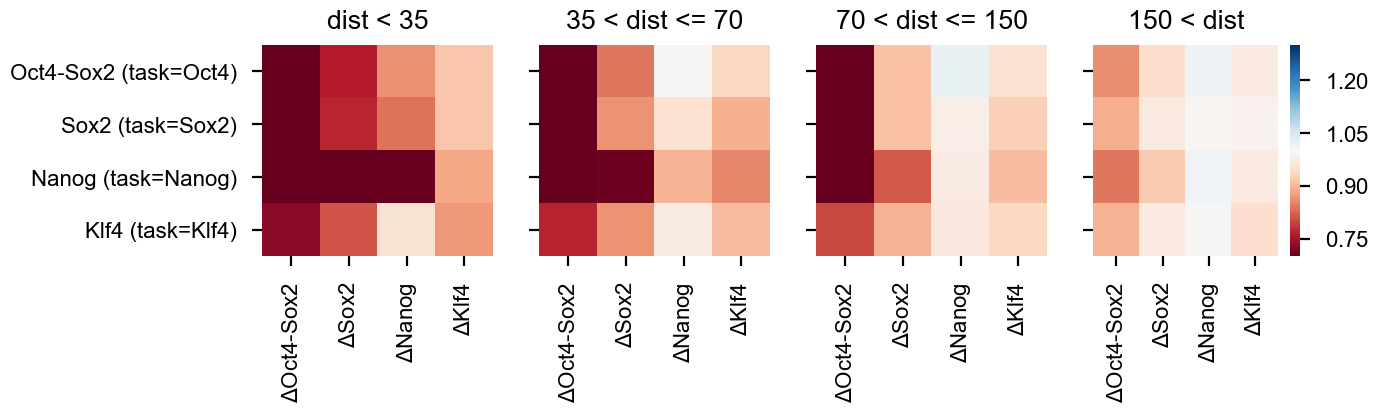

In [112]:
subsets = dist_subsets
fig,axes = plt.subplots(1, len(subsets), 
                        figsize=get_figsize(0.25*len(subsets), .8/len(subsets)), 
                        sharey=True)
for i, (subset,ax, subset_label) in enumerate(zip(subsets, axes, dist_subset_labels)):
    sns.heatmap(get_effect(dfabf_plot.query(subset), pairs_no_oct4, motifs_no_oct4,
                           agg_fn=np.median, score='max_profile_count_bt'), 
                cmap='RdBu', center=1, ax=ax, 
                cbar=i==len(subsets)-1,
                vmin=.7, vmax=1.3)
    ax.set_title(subset_label)
plt.savefig(figures_dir / 'heatmap.median_max_profile_count.directional_effect.top-profile.bleed-through-corrected.pdf')

### Binding fold-change vs distance

In [69]:
from basepair.exp.paper.config import tf_colors

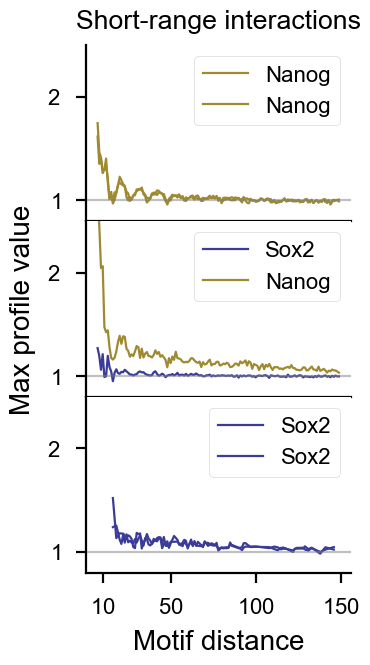

In [81]:
# for strand_combination in ['++', '-+', '+-', '--']:
fig, axes = plt.subplots(3, 1, figsize=get_figsize(.25, 2), 
                         sharex=True, 
                         sharey=True,
                         gridspec_kw=dict(wspace=0, hspace=0))
# motif_pair = ['Oct4-Sox2', 'Sox2']
for i, motif_pair in enumerate([['Nanog', 'Nanog'], 
                                ['Sox2', 'Nanog'],
                                ['Sox2', 'Sox2']]):
    motif_pair_name = '<>'.join(motif_pair)
    score = 'max_profile_count_bt'
    dfs = (dfabf_plot.query(f"motif_pair == '{motif_pair_name}'").
                query(f"score == '{score}'").
                query("center_diff > 6").
                # query(f"strand_combination == '{strand_combination}'").
                query("center_diff < 150"))
    t1 = profile_mapping[motif_pair[0]]
    t2 = profile_mapping[motif_pair[1]]
    df1 = dfs[dfs.task == t1].groupby('center_diff').x_alt_ref_pc.agg(['size', 'median', 'mad']).reset_index()
    df1 = df1[df1['size'] > 20]
    df2 = dfs[dfs.task == t2].groupby('center_diff').y_alt_ref_pc.agg(['size', 'median', 'mad']).reset_index()
    df2 = df2[df2['size'] > 20]

    ax = axes[i]
    ax.plot(df1.center_diff, 1/df1['median'], 
            label=motif_pair[0],
            color=tf_colors[profile_mapping[motif_pair[0]]]);
    ax.plot(df2.center_diff, 1/df2['median'], 
            label=motif_pair[1],
            color=tf_colors[profile_mapping[motif_pair[1]]]);

    if i == 0:
        ax.set_title(f"Short-range interactions")
    ax.axhline(1, color='grey', alpha=0.5)
    if i == 1:
        ax.set_ylabel("Max profile value")
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.set_ylim([0.8, 2.5])
    ax.spines['right'].set_visible(False)
axes[-1].set_xlabel("Motif distance")
axes[-1].set_xticks([10, 50, 100, 150]);
fig.savefig(figures_dir / f'short-range.Nanog<>Sox2.strand_combination=all.pdf')

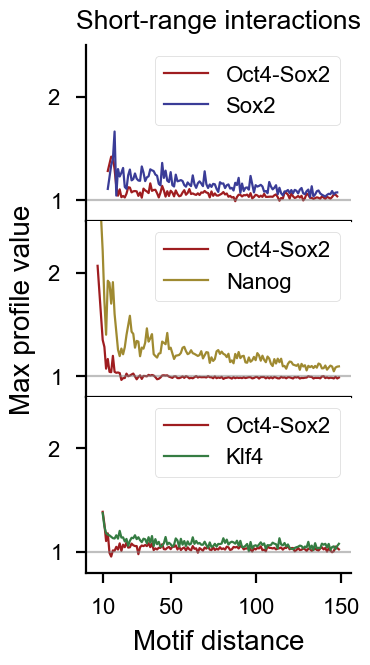

In [82]:
fig, axes = plt.subplots(3, 1, figsize=get_figsize(.25, 2), 
                         sharex=True, 
                         sharey=True,
                         gridspec_kw=dict(wspace=0, hspace=0))
# motif_pair = ['Oct4-Sox2', 'Sox2']
for i, motif_pair in enumerate([['Oct4-Sox2', 'Sox2'], 
                                ['Oct4-Sox2', 'Nanog'],
                                ['Oct4-Sox2', 'Klf4']]):
    motif_pair_name = '<>'.join(motif_pair)
    score = 'max_profile_count_bt'
    dfs = (dfabf_plot.query(f"motif_pair == '{motif_pair_name}'").
                query(f"score == '{score}'").
                query("center_diff > 6").
                # query("strand_combination == '++'").
                query("center_diff < 150"))
    t1 = profile_mapping[motif_pair[0]]
    t2 = profile_mapping[motif_pair[1]]
    df1 = dfs[dfs.task == t1].groupby('center_diff').x_alt_ref_pc.agg(['size', 'median', 'mad']).reset_index()
    df1 = df1[df1['size'] > 20]
    df2 = dfs[dfs.task == t2].groupby('center_diff').y_alt_ref_pc.agg(['size', 'median', 'mad']).reset_index()
    df2 = df2[df2['size'] > 20]
    
    ax = axes[i]
    ax.plot(df1.center_diff, 1/df1['median'], 
            label=motif_pair[0],
            color=tf_colors[profile_mapping[motif_pair[0]]]);
    ax.plot(df2.center_diff, 1/df2['median'], 
            label=motif_pair[1],
            color=tf_colors[profile_mapping[motif_pair[1]]]);
    
    if i == 0:
        ax.set_title("Short-range interactions")
    ax.axhline(1, color='grey', alpha=0.5)
    if i == 1:
        ax.set_ylabel("Max profile value")
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.set_ylim([0.8, 2.5])
    ax.spines['right'].set_visible(False)
axes[-1].set_xlabel("Motif distance")
axes[-1].set_xticks([10, 50, 100, 150]);
fig.savefig(figures_dir / 'long-range.Oct4-Sox2.strand_combination=all.pdf')

## Perturb the Oct4 enhancer

- Visualize what happens when you permute the motifs at the oct4 enhancer

In [1]:
# Imports
from basepair.exp.paper.config import *
from basepair.extractors import Variant, extract_seq
from basepair.seqmodel import SeqModel
import pybedtools
from basepair.utils import flatten_list

Using TensorFlow backend.


In [5]:
create_tf_session(0)

In [6]:
# figures dir
model_dir = models_dir / exp
fdir = Path(f'{ddir}/figures/modisco/{exp}/in-vivo-perturb/oct4-enhancer')

In [7]:
!mkdir -p {fdir}

In [9]:
ds = DataSpec.load(rdir / 'src/chipnexus/train/seqmodel/ChIP-nexus.dataspec.yml')

In [10]:
# Get counts
interval = pybedtools.create_interval_from_list(['chr17', 35503550, 35504550])

obs = {task: ds.task_specs[task].load_counts([interval])[0] for task in tasks}

In [81]:
(420+60 + 35503550, 420+120 + 35503550)

(35504030, 35504090)

In [11]:
from basepair.BPNet import BPNetSeqModel

bpnet = BPNetSeqModel.from_mdir(model_dir)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


2019-04-08 04:55:45,555 [WARNING] From /users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:497: calling conv1d (from tensorflow.python.ops.nn_ops) with data_format=NHWC is deprecated and will be removed in a future version.
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


Instructions for updating:
Use the retry module or similar alternatives.


2019-04-08 04:55:55,532 [WARNING] From /users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:198: retry (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Use the retry module or similar alternatives.


In [13]:
from genomelake.extractors import FastaExtractor

In [ ]:
fe = FastaExtractor(ds.fasta_file)
seq = fe([resize_interval(interval, input_seqlen)])

In [14]:
interval = pybedtools.create_interval_from_list(['chr17', 35503550, 35504550])

In [15]:
# Hack
bpnet.fasta_file = ds.fasta_file
bpnet.bias_model = None

In [ ]:
pred = bpnet.predict_intervals([interval], imp_method='deeplift')[0]

In [69]:
def to_neg(track):
    track = track.copy()
    track[:, 1] = - track[:, 1]
    return track
def plot_region(interval, variants=None, ):
    pred = bpnet.predict_intervals([interval], variants=variants, imp_method='deeplift')[0]
    viz_dict = OrderedDict(flatten_list([[
                        (f"{task} Pred", to_neg(pred['pred'][task])),
                        (f"{task} Imp profile", pred['imp_score'][f"{task}/weighted"] * pred['seq']),
                        # (f"{task} Imp counts", sum(pred['grads'][task_idx]['counts'].values()) / 2 * seq),
                    ] for task_idx, task in enumerate(['Oct4', 'Nanog'])]))

    viz_dict = filter_tracks(viz_dict, [420+60, 420+120])

    # Hard-code the range
    fmax = {'Imp profile': 0.265742, 'Pred': 6.5}
    fmin = {'Imp profile': -0.16751188, 'Pred': -6.5}

    ylim = []
    for k in viz_dict:
        f = k.split(" ", 1)[1]
        if "Imp" in f:
            ylim.append((fmin[f], fmax[f]))
        else:
            ylim.append((fmin[f], fmax[f]))
            
            
    colors = []
    for task in ['Oct4', 'Nanog']:
        colors.append((tf_colors[task], tf_colors[task] + "80"))  # 80 add alpha=0.5
        colors.append(None)

    fig = plot_tracks(viz_dict,
                      #seqlets=shifted_seqlets,
                      title="{i.chrom}:{i.start}-{i.end}, {i.name}".format(i=interval),
                      fig_height_per_track=0.5,
                      rotate_y=0,
                      fig_width=get_figsize(frac=.5)[0],
                      color=colors,
                      ylim=ylim,
                      use_spine_subset=True,
                      legend=False)
    sns.despine(top=True, right=True, left=False, bottom=True)
    return fig

## Original

In [76]:
fdir

PosixPath('/users/avsec/workspace/basepair/data/figures/modisco/nexus,peaks,OSNK,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE/in-vivo-perturb/oct4-enhancer')

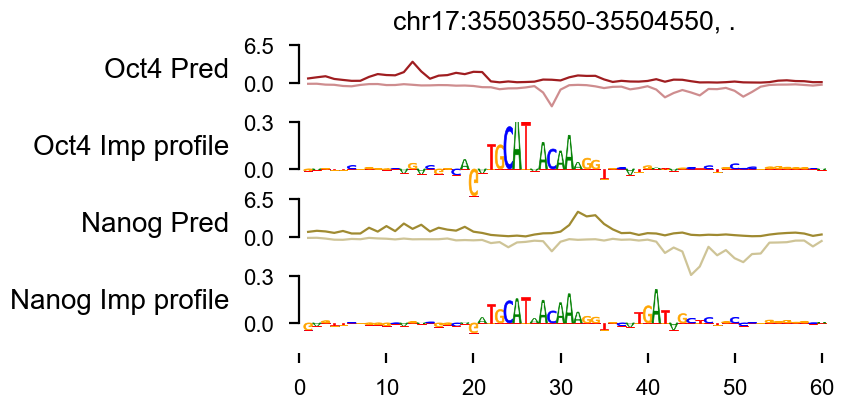

In [77]:
plot_region(interval);
plt.savefig(fdir / 'wt.pdf')

## Disrupt Oct-Sox2

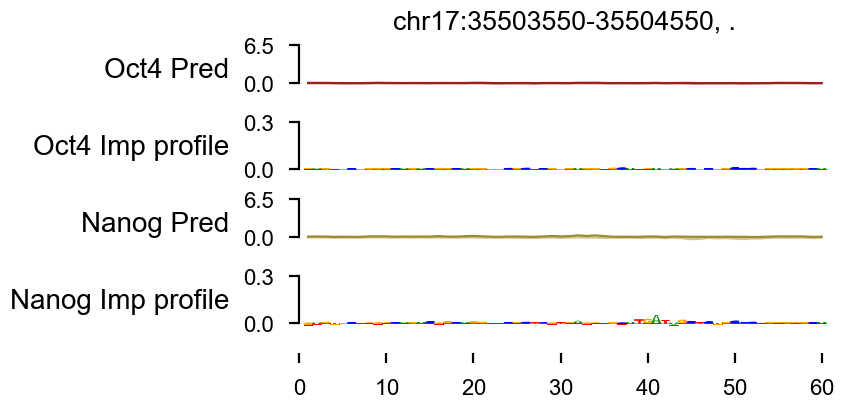

In [78]:
plot_region(interval, [Variant('chr17', 35503550 +420+80 + 1, 'ATGCATAACAA', 'GTTCGCTCGTG')]);
plt.savefig(fdir / 'dOct4-Sox2.pdf')

## Disrupt Nanog

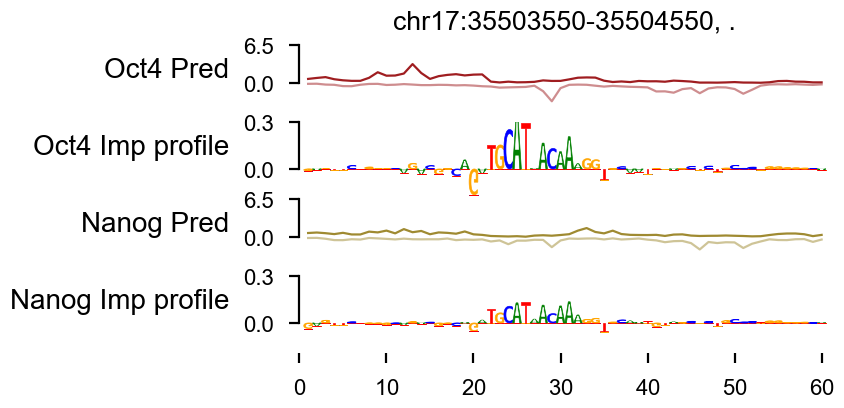

In [79]:
plot_region(interval, [Variant('chr17', 35503550 +420+98 + 1, 'TGAT', 'ATGT')]);
plt.savefig(fdir / 'dNanog.pdf')